# PCB Thermography Analysis Program
### Objective
This program is designed to process PCB thermography images (both radiometric `.tif` and non-radiometric `.jpg`/`.png` formats). The workflow involves:
1. Loading and displaying the thermography image.
2. Selecting and centering the PCB by defining the corners.
3. Defining an emissivity matrix for the PCB.
4. Calibrating the image based on emissivity and temperature data.

The program adapts to both `.tif` (radiometric) images and non-radiometric RGB images (`.jpg`, `.png`).

---


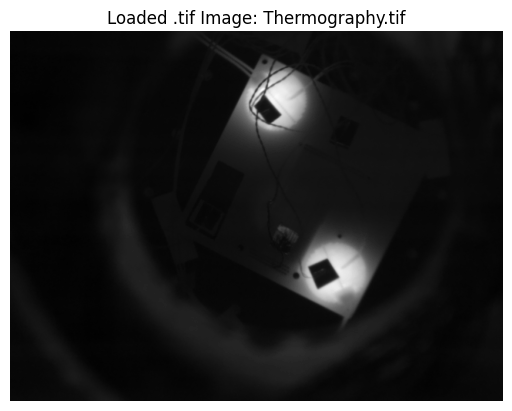

Image Thermography.tif loaded and displayed successfully.


In [1]:
# Import necessary modules for automatic reloading of modified modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Import custom image processing functions
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif
import emissivity_processing as ep
import calibration_processing as cp

# Ask the user to input the image file name (with extension)
image_name = input("Please enter the image name with extension (e.g., image.jpg or image.tif): ")

#image_name = "Thermography.tif"

#image_name = "Termografia.jpg"

# Load and display the image
image = load_and_display_image(image_name)

# Check if the image was loaded successfully
if image is not None:
    print(f"Image {image_name} loaded and displayed successfully.")
else:
    print(f"Failed to load the image {image_name}.")


## Processing the image

Converting 'F' mode image to 'L' (grayscale) for .png generation
Select 4 corners of the PCB by clicking on the image.
Corners selected: [(324, 30), (557, 144), (443, 370), (220, 256)]


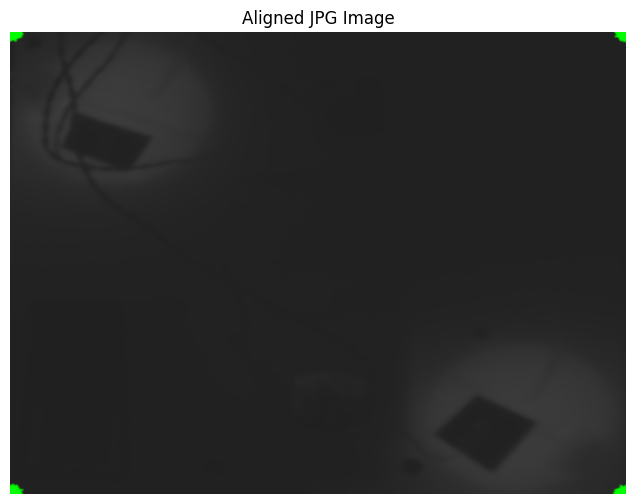

TIF image aligned and transformed.


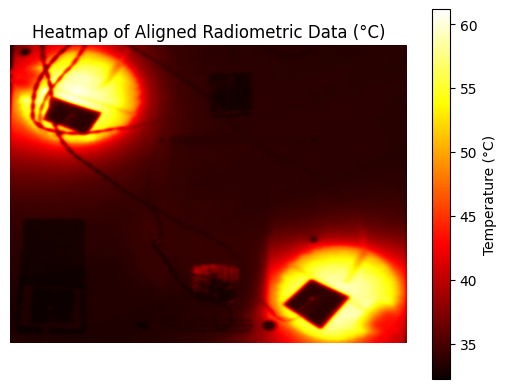

In [2]:
# Define the full image path
image_path = os.path.join("Images", image_name)

# Check the image extension (.jpg/.png or .tif)
extension = image_name.split('.')[-1].lower()

# Flag to indicate if processing a .tif file
is_tif = False

if extension in ['jpg', 'png']:
    # If the file is .jpg or .png, select corners, align the image, and calculate the RGB temperature matrix
    aligned_image_jpg, temperature_matrix_jpg, corners = select_corners_jpg(cv2.imread(image_path))
    
    # Print a portion of the RGB matrix to ensure it's not grayscale
    print("Sample of the RGB temperature matrix from the JPG image:")
    print(temperature_matrix_jpg[:5, :5, :])  # Print the first 5x5 elements of the RGB matrix

elif extension == 'tif':
    # If the file is .tif, set the flag to skip RGB processing
    is_tif = True

    # Generate a temporary .jpg for corner selection
    temp_png_path = "Images/temp_image.png"
    aligned_visual_tif, aligned_radiometric_data = select_corners_tif(image_path, cv2.imread(image_path, cv2.IMREAD_UNCHANGED), temp_png_path)

    print("TIF image aligned and transformed.")

    # Display the heatmap of the radiometric data with a proper temperature scale
    plt.imshow(aligned_radiometric_data, cmap='hot')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Heatmap of Aligned Radiometric Data (°C)")
    plt.axis('off')
    plt.show()

else:
    # Notify the user if the file format is unsupported
    print("Unsupported file format. Only .jpg, .png, and .tif are supported.")


## Calibrating emissivity


Please click five points on the perimeter of the circle.
Please click five points on the perimeter of the circle.
Please click on 4 points to define the polygon.


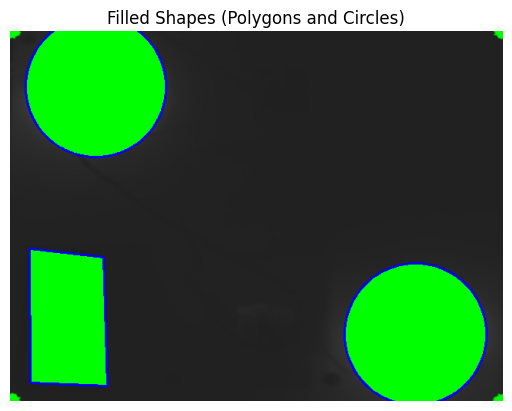

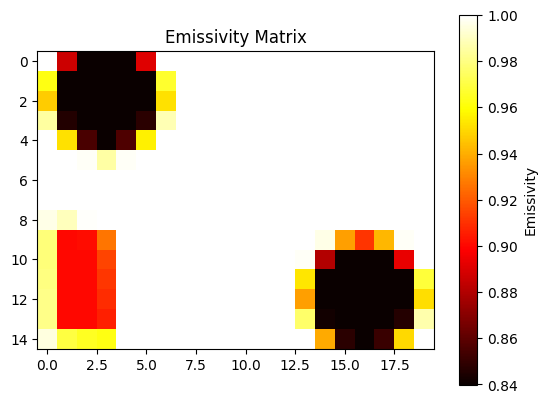


Emissivity information for defined shapes:
Circle 1: Emissivity = 0.84
Circle 2: Emissivity = 0.84
Polygon 3: Emissivity = 0.9


In [3]:
# Ask the user for the base emissivity value
base_emissivity = float(input("Enter the base emissivity value for the PCB: "))

# Process emissivity based on the image type
if extension in ['jpg', 'png']:
    emissivity_matrix = ep.process_emissivity(aligned_image_jpg, base_emissivity)
elif extension == 'tif':
    emissivity_matrix = ep.process_emissivity(aligned_visual_tif, base_emissivity)


## Calibrating final temperature heatmap

Radiometric data dimensions: (480, 640)
Emissivity matrix dimensions: (15, 20)
Calibrated temperature matrix (first 5x5 values):
[[33.157898 33.325348 33.568653 33.902138 34.47167 ]
 [33.11899  33.239826 33.56632  33.924633 34.559307]
 [33.073524 33.177578 33.55982  34.061245 34.62814 ]
 [33.092247 33.251038 33.476936 34.086758 34.744915]
 [33.046093 33.288532 33.596897 34.142963 34.889492]]


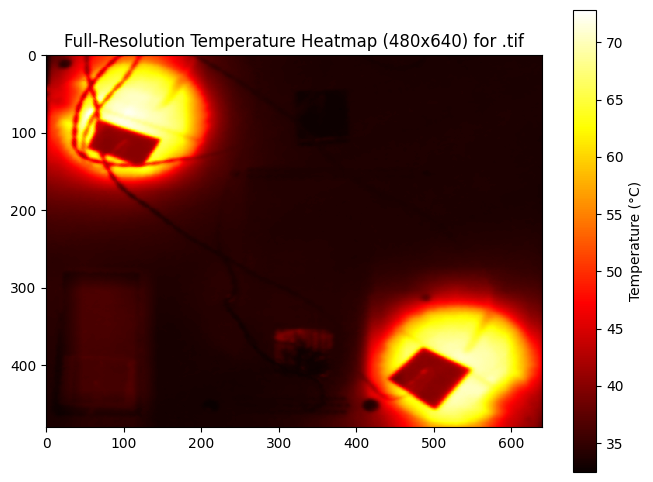

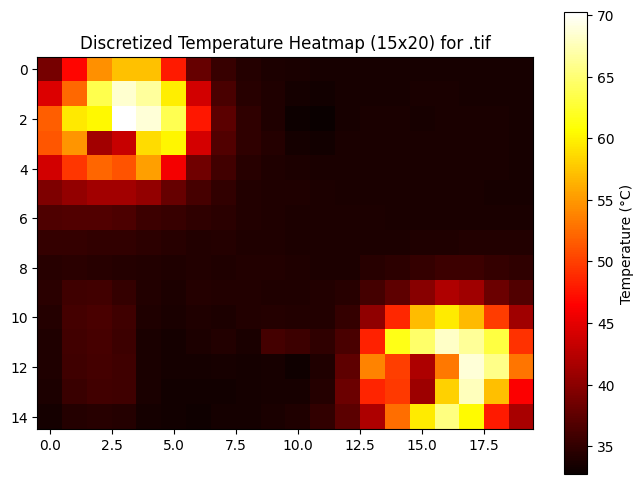

Discretized temperature matrix for .tif:
[[38.82586288 46.69852829 54.44889069 57.27084351 57.25434875 47.93234634
  37.97770691 35.26702499 34.3088913  33.92423248 33.72016525 33.60591888
  33.60703659 33.51537704 33.48840332 33.4932251  33.50270081 33.51041794
  33.57465363 33.57349396]
 [44.57914734 52.33815002 63.56121826 68.40358734 66.55729675 59.71292114
  43.91287231 36.37110138 34.4284668  34.00799561 33.3972702  33.22927094
  33.59572601 33.63296127 33.61526108 33.63957214 33.65143585 33.58994675
  33.59083176 33.58963776]
 [51.65412521 59.47135925 60.32462311 70.23991394 68.70140076 63.74279404
  47.82231522 37.30252838 34.88314438 34.0532074  33.01809692 32.75443649
  33.54788971 33.72306061 33.67832947 33.62939453 33.65902328 33.65584183
  33.7017746  33.61193848]
 [51.20871353 54.85573959 41.26998901 43.41765594 58.77958679 60.17741394
  44.07365799 36.74990082 34.92566681 34.23082733 33.4745636  33.31806946
  33.65364838 33.71447372 33.72652054 33.73428345 33.76869965 33

In [4]:
m, n = 20, 15  # Define the grid size

if extension == 'jpg':
    # Perform temperature calibration for .jpg images (initially using the RGB-based heatmap)
    calibrated_temperature_matrix = cp.calibrate_temperature('jpg', aligned_image_jpg, temperature_matrix_jpg, emissivity_matrix, m, n)
    
    # Visualize the full-scale and discretized heatmap for .jpg
    cp.visualize_temperature_matrix_jpg(calibrated_temperature_matrix)

elif extension == 'tif':
    # Perform temperature calibration for .tif images
    calibrated_temperature_matrix = cp.calibrate_temperature('tif', aligned_radiometric_data, aligned_radiometric_data, emissivity_matrix, m, n)
    
    # Visualize the .tif heatmap
    cp.visualize_temperature_matrix_tif(calibrated_temperature_matrix)


## Conclusion

In this notebook, we successfully loaded and processed thermal images in both .jpg and .tif formats. We applied corner selection, image alignment, emissivity calibration, and temperature matrix visualization. This workflow provides an efficient method to analyze thermographic data with proper calibration and visualization tools.

Next steps include refining the image processing and calibration methods to enhance accuracy and performance for various image types.
